In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

from csbdeep.utils import normalize
from skimage.io import imread

import tensorflow as tf

2021-07-27 14:32:16.287520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
gorbsky_dir = "/data/backup/cullen/gorbsky_data/"
load_dir = gorbsky_dir+"/input_data/"
track_dir = gorbsky_dir+"tracking_videos/"
roi_dir = gorbsky_dir+"rgn_reader/"
cellID_dir = gorbsky_dir+"cell_data/"

files = [f[:-4] for f in sorted(os.listdir(load_dir)) if f.endswith(".tif")]
filenames = []
classification = []
fr = 5
count = 0
for file in files:
    df = pd.read_csv(cellID_dir+file+".csv")
    tracked_cells = [f[:-4] for f in os.listdir(track_dir+file+"_tracked/") if f.endswith(".tif")]
    for trackID in tqdm(tracked_cells):
        if trackID in df["trackID"].values:
            if len(df[df["trackID"]==trackID]) == 1:
                count += 1
                stages = np.zeros((289,7))
                stages[:,0] = 1
                neb = df[df["trackID"]==trackID]["NEB"].item()
                if not np.isnan(neb):
                    stages[int(neb/fr),0] = 0
                    stages[int(neb/fr),1] = 1
                met = df[df["trackID"]==trackID]["Met"].item()
                if not np.isnan(met):
                    stages[int(met/fr),0] = 0
                    stages[int(met/fr),2] = 1
                ana = df[df["trackID"]==trackID]["Ana"].item()
                if not np.isnan(ana):
                    stages[int(ana/fr),0] = 0
                    stages[int(ana/fr),3] = 1
                fat = df[df["trackID"]==trackID]["Fatigue"].item()
                if not np.isnan(fat):
                    stages[int(fat/fr),0] = 0
                    stages[int(fat/fr),4] = 1
                dea = df[df["trackID"]==trackID]["Death"].item()
                if not np.isnan(dea):
                    stages[int(dea/fr),0] = 0
                    stages[int(dea/fr),5] = 1
                mul = df[df["trackID"]==trackID]["Multipolar"].item()
                if not np.isnan(mul):
                    stages[int(mul/fr),0] = 0
                    stages[int(mul/fr),6] = 1
                classification.append(stages)
                filenames.append(track_dir+file+"_tracked/"+trackID+".tif")
        elif count>0:
            stages = np.zeros((289,7))
            stages[:,0] = 1
            count -= 1
            classification.append(stages)
            filenames.append(track_dir+file+"_tracked/"+trackID+".tif")
filenames = np.array(filenames)
classification = np.array(classification)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 5942.94it/s]


In [3]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1
n = len(filenames)
index = [int(i) for i in np.linspace(0,n-1,n)]
np.random.shuffle(index)

X_train, X_val, X_test, y_train, y_val, y_test = (filenames[index[:int(train_frac*n)]],
                                                  filenames[index[int(train_frac*n):int((train_frac+val_frac)*n)]],
                                                  filenames[index[int((train_frac+val_frac)*n):]],
                                                  classification[index[:int(train_frac*n)]],
                                                  classification[index[int(train_frac*n):int((train_frac+val_frac)*n)]],
                                                  classification[index[int((train_frac+val_frac)*n):]])
n

334

In [4]:
X_train.shape

(267,)

In [5]:
y_train.shape

(267, 289, 7)

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=16, x_dim=(289,128,128,1), y_dim=(289,7), shuffle=True):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.list_IDs))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.x_dim))
        y = np.empty((self.batch_size, *self.y_dim))
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = np.swapaxes(imread(X_train[0]),0,2).reshape(289,128,128,1)
            for j in range(289):
                X[i,j,] = normalize(X[i,j,])
            y[i] = self.labels[i]
        return X, y

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
tf.keras.backend.clear_session()

model_lstm = tf.keras.models.Sequential([
    layers.TimeDistributed(layers.MaxPooling2D(2), input_shape=(289,128,128,1)),
    layers.ConvLSTM2D(4, 3, padding="same", return_sequences=True, activation="relu"),
#     layers.ConvLSTM2D(32, 3, padding="same", return_sequences=True, activation="relu"),
    layers.TimeDistributed(layers.MaxPooling2D(2)),
#     layers.ConvLSTM2D(32, 3, padding="same", return_sequences=True, activation="relu"),
    layers.TimeDistributed(layers.MaxPooling2D(2)),
    layers.TimeDistributed(layers.Flatten()),
    layers.TimeDistributed(layers.Dense(32, activation="relu")),
    layers.TimeDistributed(layers.Dropout(0.5)),
    layers.TimeDistributed(layers.Dense(7, activation="softmax"))])
    
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy','Precision']
)
model_lstm.summary()

2021-07-27 14:32:17.788350: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-27 14:32:17.789319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-27 14:32:17.909799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2021-07-27 14:32:17.910474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2021-07-27 14:32:17.910514: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-27 14:32:17.913442: I

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 289, 64, 64, 1)    0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 289, 64, 64, 4)    736       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 289, 32, 32, 4)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 289, 16, 16, 4)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 289, 1024)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 289, 32)           32800     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 289, 32)           0

In [8]:
train = DataGenerator(X_train, y_train)
val = DataGenerator(X_val, y_val)
history = model_lstm.fit(train, epochs=15, verbose=1, validation_data=val)

2021-07-27 14:32:22.580357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-27 14:32:22.580784: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601000000 Hz


Epoch 1/15


2021-07-27 14:32:26.152440: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-27 14:32:26.659344: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-07-27 14:32:29.404916: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


16/16 [==============================] - 67s 4s/step - loss: 1.8653 - accuracy: 0.7771 - precision: 0.1176 - val_loss: 1.0408 - val_accuracy: 0.9948 - val_precision: 0.0000e+00
Epoch 2/15
16/16 [==============================] - 59s 4s/step - loss: 0.7606 - accuracy: 0.9241 - precision: 0.9634 - val_loss: 0.0880 - val_accuracy: 0.9948 - val_precision: 0.9948
Epoch 3/15
16/16 [==============================] - 58s 4s/step - loss: 0.1864 - accuracy: 0.9715 - precision: 0.9826 - val_loss: 0.0538 - val_accuracy: 0.9948 - val_precision: 0.9948
Epoch 4/15
16/16 [==============================] - 58s 4s/step - loss: 0.2230 - accuracy: 0.9779 - precision: 0.9843 - val_loss: 0.0829 - val_accuracy: 0.9948 - val_precision: 0.9948
Epoch 5/15
16/16 [==============================] - 58s 4s/step - loss: 0.2814 - accuracy: 0.9814 - precision: 0.9819 - val_loss: 0.0841 - val_accuracy: 0.9948 - val_precision: 0.9948
Epoch 6/15
16/16 [==============================] - 59s 4s/step - loss: 0.2549 - accura

In [23]:
model_lstm.save(gorbsky_dir+"docker_PhaseTwo/model/")

2021-07-27 15:09:00.882314: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /data/backup/cullen/gorbsky_data/docker_PhaseTwo/model/assets


In [9]:
# model_lstm.predict()
test = DataGenerator(X_train, y_train,batch_size=len(X_train))
y_pred = model_lstm.predict(test.__getitem__(0)[0])
# for i in tqdm(range(len(X_test))):
#     y_pred = model_lstm.predict(test.__getitem__(i)[0])
#     print(np.sum(np.argmax(y_pred,axis=-1)==np.argmax(test.__getitem__(i)[1],axis=-1)))
# #     print([j.shape for j in train.__getitem__(i)])

In [10]:
[i.shape for i in train.__getitem__(0)]

[(16, 289, 128, 128, 1), (16, 289, 7)]

In [21]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, roc_auc_score

def binarize(Y, Y_hat):
    o = {}
    auc = roc_auc_score(Y, Y_hat, multi_class='ovr')
    return auc

def evaluate(Y, Y_hat):
    o = {}
    for i in range(Y.shape[1]):
        y = Y.iloc[:,i]
        y_hat = Y_hat.iloc[:,i]
        o[Y.columns[i]] = {
            "Precision": precision_score(y, y_hat),
            "Recall": recall_score(y, y_hat)
            #"AUC": sklearn.metrics.roc_auc_score(y, y_hat)
        }
    return pd.DataFrame(o)

In [12]:
from tensorflow.keras.utils import to_categorical

y_df = pd.DataFrame(test.__getitem__(0)[1].reshape((-1,7)),columns=['N/a','NEB','MET','ANA','Fatigue','Death','Multipolar'])
y_pred_df = pd.DataFrame(y_pred.reshape((-1,7)),columns=['N/a','NEB','MET','ANA','Fatigue','Death','Multipolar'])
y_pred_binary_df = pd.DataFrame(to_categorical(np.argmax(y_pred,axis=-1),7).reshape((-1,7)),columns=['N/a','NEB','MET','ANA','Fatigue','Death','Multipolar'])


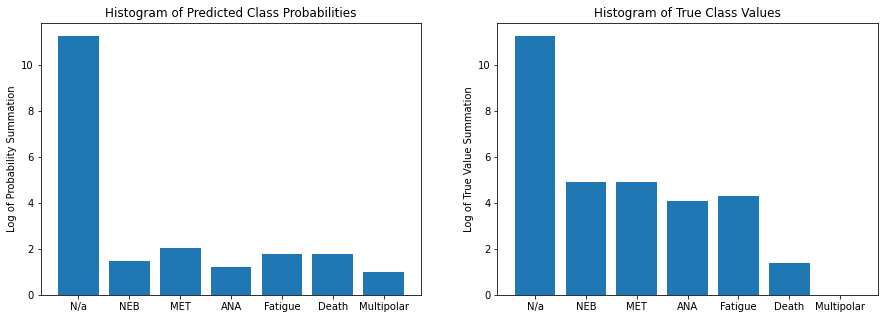

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.bar(y_pred_df.columns,np.log(y_pred_df.sum()+1))
plt.title("Histogram of Predicted Class Probabilities")
plt.ylabel("Log of Probability Summation")

plt.subplot(122)
plt.bar(y_df.columns,np.log(y_df.sum()+1))
plt.title("Histogram of True Class Values")
plt.ylabel("Log of True Value Summation")

plt.show()

In [83]:
print(roc_auc_score(y_df.drop(columns=['Multipolar']),np.array(y_pred_df['N/a']).reshape(-1,1)))
print(roc_auc_score(y_df.drop(columns=['Multipolar']),np.array(y_pred_df['NEB']).reshape(-1,1)))
print(roc_auc_score(y_df.drop(columns=['Multipolar']),np.array(y_pred_df['MET']).reshape(-1,1)))
print(roc_auc_score(y_df.drop(columns=['Multipolar']),np.array(y_pred_df['ANA']).reshape(-1,1)))
print(roc_auc_score(y_df.drop(columns=['Multipolar']),np.array(y_pred_df['Fatigue']).reshape(-1,1)))
print(roc_auc_score(y_df.drop(columns=['Multipolar']),np.array(y_pred_df['Death']).reshape(-1,1)))

0.48880358826495185
0.5172532032455068
0.518918820910883
0.5172532032455068
0.5172532032455068
0.5172532032455068


In [98]:
fpr, tpr, thresh = roc_curve(np.argmax(np.array(y_df.drop(columns=['Multipolar'])),axis=-1),np.array(y_pred_df['N/a']).reshape(-1,1),pos_label=1)


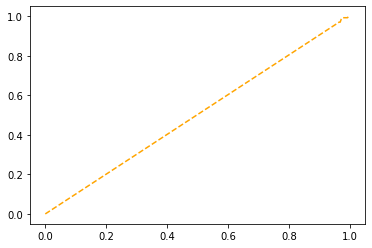

In [99]:
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Class 0 vs Rest')